*This notebook uses ipywidgets. Run Jupyter with: `jupyter nbextension enable --py --sys-prefix widgetsnbextension`*

## Example Exercises

The following exercises demonstrate various ways of programming the robot.

In [ ]:
#Wake up the kernel
print('Hello World!')

In [5]:
%matplotlib inline
#This cell may take some time to run
# because the matplotlib requirement is quite large...

from ev3dev.auto import *
import time
from __future__ import division
from math import pi
from ipywidgets import widgets, interact

def wait(time_in_ms):
    time.sleep( time_in_ms / 1000)

### Driving Basics

Familiarisation with driving:

- motor assignment;
- motor runs commands;
- motor stop commands (*coast*, *brake*, *hold*).

----

In [3]:
#Drive demo based on https://github.com/rhempel/ev3dev-lang-python/blob/master/demo/auto-drive.py
#Originally Copyright (c) 2015 Denis Demidov <dennis.demidov@gmail.com>


# In this demo an Explor3r robot with touch sensor attachement drives
# autonomously. It drives forward until an obstacle is bumped (determined by
# the touch sensor), then turns in a random direction and continues. The robot
# slows down when it senses obstacle ahead (with the infrared sensor).
#
# The program may be stopped by pressing any button on the brick.
#
# This demonstrates usage of motors, sound, sensors, buttons, and leds.

from time import sleep
from random import choice, randint

from ev3dev.auto import *

# Connect two large motors on output ports B and C:
motors = [LargeMotor(address) for address in (OUTPUT_B, OUTPUT_C)]

# Every device in ev3dev has `connected` property. Use it to check that the
# device has actually been connected.
assert all([m.connected for m in motors]), \
    "Two large motors should be connected to ports B and C"

In [4]:
def demo_start_motors(duty_cycle_sp=None):
    """
    Start both motors. `run-direct` command will allow to vary motor
    performance on the fly by adjusting `duty_cycle_sp` attribute.
    """
    sp_set=False
    for m in motors:
        m.run_direct() if duty_cycle_sp is None else m.run_direct(duty_cycle_sp=duty_cycle_sp)
        
        if m.duty_cycle_sp!=0: sp_set=True
            
    if not sp_set:
        print('**WARNING**: duty_cycle_sp is zero for both motors')

In [5]:
demo_start_motors()

In [6]:
demo_start_motors(75)

In [6]:
# Stop the motors before exiting.
def demo_stop_motors():
    for m in motors:
        m.stop()

In [7]:
demo_stop_motors()

In [9]:
def demo_turn():
    """
    Turn the robot in random direction.
    At the end of the turn, the motors will be switched off.
    """

    # Turn the robot wheels in opposite directions from 1/4 to 3/4 of a second.
    # Use `random.choice()` to decide which wheel will turn which way.
    power = choice([(1, -1), (-1, 1)])
    t = randint(250, 750)

    for m, p in zip(motors, power):
        m.run_timed(duty_cycle_sp=p*75, time_sp=t)

    # Wait until both motors are stopped:
    while any(m.state for m in motors):
        sleep(0.1)

In [12]:
demo_start_motors()

In [13]:
demo_turn()

In [21]:
def demo_backup():
    """
    Back away from an obstacle.
    """

    # Sound backup alarm.
    Sound.tone([(1000, 500, 500)] * 3).wait()

    # Turn backup lights on:
    for light in (Leds.LEFT, Leds.RIGHT):
        Leds.set_color(light, Leds.RED)

    # Stop both motors and reverse for 1.5 seconds.
    # `run-timed` command will return immediately, so we will have to wait
    # until both motors are stopped before continuing.
    for m in motors:
        m.stop(stop_command='brake')
        m.run_timed(duty_cycle_sp=-50, time_sp=1500)

    # When motor is stopped, its `state` attribute returns empty list.
    # Wait until both motors are stopped:
    while any(m.state for m in motors):
        sleep(0.1)

    # Turn backup lights off:
    for light in (Leds.LEFT, Leds.RIGHT):
        Leds.set_color(light, Leds.GREEN)

In [22]:
demo_start_motors()

In [23]:
demo_backup()

In [24]:
# Connect infrared and touch sensors.
ir = InfraredSensor(); assert ir.connected
ts = TouchSensor();    assert ts.connected

In [ ]:
# Put the infrared sensor into proximity mode.
ir.mode = 'IR-PROX'

In [26]:
ir.modes

[u'IR-PROX', u'IR-SEEK', u'IR-REMOTE', u'IR-REM-A', u'IR-S-ALT', u'IR-CAL']

In [ ]:
# Simple get out clause - stop on brick button press
btn = Button()

# Run the robot until a button is pressed.
start()
while not btn.any():

    if ts.value():
        # We bumped an obstacle.
        # Back away, turn and go in other direction.
        backup()
        turn()
        start()

    # Infrared sensor in proximity mode will measure distance to the closest
    # object in front of it.
    distance = ir.value()

    if distance > 60:
        # Path is clear, run at full speed.
        dc = 90
    else:
        # Obstacle ahead, slow down.
        dc = 40

    for m in motors:
        m.duty_cycle_sp = dc

    sleep(0.1)

----

Simple example of a widget to control / report on current duty cycle (crude speed control).

In [ ]:
m = LargeMotor(OUTPUT_B)

def run_m(dc):
    m.duty_cycle_sp=dc
    print('Duty cycle: {}'.format(dc))

interact(run_m, dc=(-100,100,10))

m.run_direct()

In [9]:
m.stop()

### Remote Control

How to handle the Lego remote control...

In [6]:
import threading

def checkThreads():
    print(', '.join(threading.enumerate()))

#Parameter t is here is just a placeholder in case we want to pass in a specific thread to kill?
#- Timers get cancelled
#- Threads get joined?
# Can we detect type and clear all the ones we started?
#Start of notebook get a list of all threads, then clear back to that list?
def killThreads(n=None,t=None):
    if n is None:
        n=['Repeated Timer','Data logger']
    for t in threading.enumerate():
        if t.getName() in n:
            t.cancel()
            
#We can then kill any threads we know we've created if we have to...
killThreads()

#http://stackoverflow.com/a/13151299/454773down vote
from threading import Timer

class RepeatedTimer(object):
    def __init__(self, interval, function, name='Repeated Timer', *args, **kwargs):
        self._timer     = None
        self.interval   = interval
        self.function   = function
        self.name=name
        self.args       = args
        self.kwargs     = kwargs
        self.is_running = False
        self.start()

    def _run(self):
        self.is_running = False
        self.start()
        self.function(*self.args, **self.kwargs)

    def start(self):
        if not self.is_running:
            self._timer = Timer(self.interval, self._run)
            #name the timer so we can spot it and kill it
            self._timer.setName(self.name)
            self._timer.start()
            self.is_running = True

    def stop(self):
        self._timer.cancel()
        self.is_running = False

To start with, let's see if we can use the remote control to control the lights on the EV3 brick. 

In [57]:
R=RemoteControl()

In [ ]:
r_output = widgets.Text()

L=Leds
L.all_off()

def test_remote_reading():
    ''' Indicate the last button pressed '''
    txt= 'No button pressed' if not R.any() else 'Buttons pressed: {}'.format(','.join(R.buttons_pressed))
    r_output.value='Remote actions: {}'.format(txt)
    
    if 'red_up' in txt:
        L.set_color(L.RIGHT, L.RED)
    elif 'red_down' in txt:
        L.set_color(L.LEFT, L.RED)
    elif 'blue_up' in txt:
        L.set_color(L.RIGHT, L.GREEN)
    elif 'blue_down' in txt:
        L.set_color(L.LEFT, L.GREEN)


r_output

In [120]:
t_r=RepeatedTimer(0.1,test_remote_reading)

Exception in thread Repeated Timer:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 810, in __bootstrap_inner
    self.run()
  File "/usr/lib/python2.7/threading.py", line 1082, in run
    self.function(*self.args, **self.kwargs)
  File "<ipython-input-6-a379ec017516>", line 38, in _run
    self.function(*self.args, **self.kwargs)
  File "<ipython-input-119-05cc41968287>", line 11, in test_remote_reading
    L.set_color(L.RIGHT, L.RED)
  File "/usr/lib/python2.7/dist-packages/ev3dev/ev3.py", line 76, in set_color
    l.brightness_pct = v * pct
  File "/usr/lib/python2.7/dist-packages/ev3dev/core.py", line 1777, in brightness_pct
    self.brightness = value * self.max_brightness
  File "/usr/lib/python2.7/dist-packages/ev3dev/core.py", line 1695, in max_brightness
    return self.get_attr_int('max_brightness')
  File "/usr/lib/python2.7/dist-packages/ev3dev/core.py", line 207, in get_attr_int
    return int(self._get_attribute(attribute))
ValueError: in

In [ ]:
t_r.stop()

In [ ]:
killThreads()

### Travel in a straight line for a specified distance based on tacho count

The basic tyre supplied with the Lego EV3 has a diameter of 56mm (it's written on the tyre).

This means that we can programme the robot to travel a particular distance.

First, let's define some constants and do some simple sums to work out the values of certain derived quantities.

In [ ]:
left_motor=LargeMotor(OUTPUT_A)
right_motor=LargeMotor(OUTPUT_D)

#Assume that the left motor and right motor have similar properties...
COUNT_PER_ROTATION =left_motor.count_per_rot

#Degrees per tacho count
DEGREES_PER_COUNT = 360 / COUNT_PER_ROTATION 

#Wheel size in mm = 2 * pi * radius =  pi * diameter
WHEEL_CIRCUMFERENCE = pi * 56

#Distance in millimeters per tacho count
MM_PER_COUNT = WHEEL_CIRCUMFERENCE / COUNT_PER_ROTATION

#Distance per degree
MM_PER_DEGREE = WHEEL_CIRCUMFERENCE / 360

#Distance per tacho count
COUNT_PER_MM = COUNT_PER_ROTATION / WHEEL_CIRCUMFERENCE

Specify how far we want to travel.

In [ ]:
#Set the distance to travel in centimeters
distance_to_travel_cm = 10

Create a simple function to convert from centimeters to millimeters.

In [ ]:
#Define a function to convert centimeters to millimeters
def mm_from_cm(cm):
    return 10 * cm

Do the conversion...

In [7]:
distance_to_travel_mm = mm_from_cm( distance_to_travel_cm )

If we know the distance, and we know the distance per tach count, we can calculate the tacho count required to go a particular distance:

In [8]:
#Calculate tacho count required to travel that distance
count_for_distance = distance_to_travel_mm * COUNT_PER_MM

Use that calculated tacho count value to turn on the motors for that particular count.

In [9]:
#Drive for a specified tacho count

#Set the motor speed
dutycycle=40

#Turn on the motors for the required tacho count
left_motor.run_to_rel_pos(position_sp=count_for_distance, duty_cycle_sp=dutycycle )
right_motor.run_to_rel_pos(position_sp=count_for_distance, duty_cycle_sp=dutycycle )

Having tested the code, we might then create a function:

In [ ]:
def travel_N_cm( distance_to_travel_cm , dutycycle= 45):
    distance_to_travel_mm = mm_from_cm( distance_to_travel_cm )
    count_for_distance = distance_to_travel_mm * COUNT_PER_MM
    left_motor.run_to_rel_pos(position_sp=count_for_distance, duty_cycle_sp=dutycycle )
    right_motor.run_to_rel_pos(position_sp=count_for_distance, duty_cycle_sp=dutycycle )

Test the function - forward 5cm, then back 5cm:

In [ ]:
travel_N_cm(5)

In [ ]:
travel_N_cm(-5)

Note that if we call the forward and back functions together, the second command is issued *immediately* after the first, which means that the first is unlikely to be able to take effect.

What this means is that we need to check that the commands issued by the `travel_N_cm` function the first time we call it have completed before we call it again.

In [ ]:
##NOT TESTED##
travel_N_cm(5)

while 'running' in left_motor.state or 'running' in right_motor.state :
    time.sleep(0.1)

travel_N_cm(-5)

In [ ]:
def actually_travel_N_cm():
    #add some logic to test that we've actually travelled the distance
    pass

### Turn Through N Degrees

To turn through 90 degrees, for example, we can either turn on the spot or turn about a particular angle.

#### Turning About One Wheel

To turn about one wheel, turn one wheel on and leave the other one switched off.

To turn through that particular angle (ninety degrees), we could either calculate how far the activated wheel needs to turn to cover one quarter of the circumference of a circle with a *radius* equal to the width of the robot's *track* (that is, distance between the mid-points of its wheels), *or* we could turn the motor on for a set period of time, which requires that we *calibrate* the robot in order to get an estimate of the time needed to turn through 360 degrees, for example, and divide the resulting time by 4.

### Turning on the Spot

To turn on the spot, turn one motor forward and the other one backward at the same speed.

Again, there are at least the following two ways of calculating this. One is to calculate the distance turned by each wheel (a quarter of the circumference of a circle with *diameter* equal to the *track* of the robot) or a quarter of the time take to turn the robot through one complete turn on the spot. 

### Navigate a Square

I'm not sure what the best way of getting the ev3dev to finish driving a distance before it starts driving another distance is?

In [ ]:
#drive one edge
def one_edge(length=20):
    pass

#Turn ninety degrees
def turn(typ='onspot',angle=90):
    pass

def drive_square(side=20):
    done = False
    for i in range(4):
        while not done:
            one_edge(side)
        while not done:
            turn(90)

        

### Color Sensor Inspector

For the color sensor inspector, we'll introduce a timer that lets us repeatedly check the sensor values with a specified sample rate.

The timer actually works by repeatedly defining *another* timer every time it is called, until we tell it to stop.

In [ ]:
#UNTESTED
#Based on https://github.com/rhempel/ev3dev-lang-python/blob/1c9265db6dd5439884a4764f3a84f8ec6bc85220/tests/motor/ev3dev_port_logger.py
#Another approach is just to run a parallel thread
#This is more akin to the RCX task
#Use this as a model for student's own task?
class myTaskThread(threading.Thread):
    def __init__(self, name='Task thread'):
        threading.Thread.__init__(self)
        self.name = name
        self.done = threading.Event()

    def run(self):
        #to do
        while not self.done.isSet():
            pass
    
    def stop(self, timeout=None):
        self.done.set()
        self.join(timeout)


Let's define a colour sensor and check the mode:

In [7]:
cs = ColorSensor()
cs.mode

Now define a simple text widget to display the colour sensor value (the widget will remain empty until you call the timer to poll the sensor and run the widget updating function `test_color_sensor()`).

In [19]:
cs.mode='COL-REFLECT'

In [34]:
cs_output = widgets.Text()

colorMap={0:'No color', 1:'Black',2: 'Blue',3: 'Green',
          4: 'Yellow', 5: 'Red', 6: 'White', 7: 'Brown'}

def test_color_sensor():
    if cs.mode=='COL-REFLECT':
        cs_output.value='Colour sensor output: {}'.format(cs.value())
    elif cs.mode=='COL-COLOR':
        cs_output.value='Colour sensor output: {} ({})'.format(cs.value(), colorMap[cs.value()])

#The output units / value look wrong to me? Decimeters, maybe?
cs_output

In [40]:
#Call the timer that polls the sensor
t_cs=RepeatedTimer(0.1,test_color_sensor)

In [41]:
#Stop polling the sensor
t_cs.stop()

Now change the color mode and start the timer again to see the difference.

In [19]:
cs.mode='COL-COLOR'

In [39]:
#EMERGENCY STOP BUTTON
killThreads()

### Line Stopper

Continue driving forward until you see a black line on a lighter background.

### Line Colour Detector

Report on the colour of various colour lines using the colour sensor.

### Cliff Edge Stopper

Continue driving forward until you see over the edge of a cliff. (Light sensor? Or proximity sensor?)

### Indicate Whether or Not the Touch Sensor is Being Pressed

We can create a simple test programme to illustrate whether the touch sensor is being pressed that will switch the colour of the left and right LEDs depending on whether the touch sensor switch is closed or not.

In [ ]:
#Set colour according to switch
ts = TouchSensor()

#Simple timoeut routine from http://stackoverflow.com/a/13293316/454773
timeout = time.time() + 10   # 10 seconds from now

while True:
    #Set Leds depending on whether switch is pressed or not
    L.set_color(L.RIGHT, L.RED if ts.value() else L.GREEN)
    L.set_color(L.LEFT, L.GREEN if ts.value() else L.RED)
    
    #Break out of the loop after a certain amount of time
    if time.time() > timeout:
        break

Modify the program to say *"ouch"* when the robot bumps into something

### Touch Sensor Bumper

Test activities to use the touch sensor:

- forward until stop on bump;
- reverse and turn set angle on bump, then forward;
- reverse and turn random angle on bump, then forward.

Add an additional indicator that the robot has bumped by saying "ouch" in the reverse phase.

### Infrared Range Sounder
Provide an audio alert as something gets closer to the infra-red sensor.

In [59]:
ir=InfraredSensor()
ir.mode='IR-PROX'

To provide an audible signal correpsonding to proximity, set a frequency that is inversely proportional to the distance and then use the `Sound.tone(frequency,duration).wait()` construction to generate the sound.

In [69]:
#Set the frequency inversely proportional to the distance
#The frequency should go up as we get closer
#Infra-red range is 0..100, map onto range 20,000..~200
def frequency_by_dist_ir(dist):
    if dist!='' and dist>=0:
        return  20000 / (dist+1)
    return -1        

In [11]:
ir_output = widgets.Text()

def infrared_range():
    try:
        d=ir.value()
    except:
        d=''
    ir_output.value='Infra-red range: {}'.format(d)

def infrared_beeper():
    try:
        d=ir.value()
    except:
        d=''
    f=frequency_by_dist_ir(d)
    if f>0:
        Sound.tone(f,10)

def infrared_response():
    infrared_range()
    infrared_beeper()

ir_output

In [81]:
irt = RepeatedTimer(0.2, infrared_response)

In [82]:
irt.stop()

### Infra-Red Proximity Bumper

Try to pre-empt the bumper bumping by using the proximity sensor. See how close you can get to the obstacle before taking avoiding action and before actually bumping.



### Homing Beacon

The robot should find its way back to the sensor beacon.

Start by trying to report on the likely direction of the homing beacon.

In [37]:
ir=InfraredSensor()
ir.mode='IR-SEEK'

In [42]:
beacon_output = widgets.Text()

def ir_beacon_distDir(channel=1):
    beacon_output.value='Beacon heading: {}, and range: {}'.format(ir.value(2*(channel-1)),
                                                                   ir.value(2*(channel-1)+1))

beacon_output

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [43]:
t_beacon=RepeatedTimer(0.1, ir_beacon_distDir)

In [44]:
t_beacon.stop()

### Gyro Test

Simple experiment to see how the gyro works

### Simple Ultrasound Test

*Is there likely to be confusion around the ultrasound sensor when working with multiple robots / ultrasound sensors?*

In [24]:
us=UltrasonicSensor()

In [15]:
us_output = widgets.Text()

US_UNITS=us.units

def ultrasound_range():
    us_output.value='Ultrasound range: {} {}'.format(us.value(), US_UNITS)

#The output units / value look wrong to me? Decimeters, maybe?
us_output

The installed widget Javascript is the wrong version.


In [18]:
rt = RepeatedTimer(0.1, ultrasound_range)

In [19]:
#Stop the timer
rt.stop()

### Ultrasonic Range Sounder

Provide an audio alert as something gets closer to the ultrasonic sensor.

In [ ]:
#Set the frequency inversely proportional to the distance
#The frequency should go up as we get closer
def frequency_by_dist_us(dist):
    return  100000 / dist

In [27]:
def ultrasound_beeper():
    f=frequency_by_dist_us(us.value())
    if f>0:
        Sound.tone(f,10)

In [40]:
urt = RepeatedTimer(0.2, ultrasound_beeper)

In [ ]:
urt.stop()

### Gyro Navigation - Drive Around a Square of Known Side

Use the gyro to turn the right angles.

In [161]:
def demo_forward(tsp=1000,dc=20):
    for m in motors:
        m.run_timed(time_sp=tsp, duty_cycle_sp=dc)

In [162]:
def demo_turn(direction=(-1,1),dc=25):
    for m, p in zip(motors, direction):
        m.run_timed(duty_cycle_sp=p*dc, time_sp=100)

    # Wait until both motors are stopped:
    while any(m.state for m in motors):
        sleep(0.1)

In [155]:
gs=GyroSensor()
gs.mode='GYRO-ANG'

#If we're within ish degrees that's close enough
ish=2

def gyro_turn_till_relative(bearing):
    #What heading does the gyro currently give, in degrees?
    current_heading=gs.value() % 360
    #The target heading is the current heading plus the desired bearing
    target_heading=(360+current_heading+bearing) % 360
    #Keep turning while the current heading is more than ish degrees from the target heading
    #Should really optimise the turn so we turn the shortest angle
    while abs(( gs.value() % 360)-target_heading) >ish:
        if gs.value() % 360 -target_heading <0:
            demo_turn((-1,1))
        else:
            demo_turn((1,-1))

In [128]:
demo_forward()

In [168]:
gyro_turn_till_relative(90)

### Simple Data Logging

While driving over coloured tapes, use the colour sensor to log the colours seen, then interprest the chart:

- identify the colours;
- how would you work out the *width* of the pieces of coloured tape?

In [129]:
from threading import Timer
from datetime import datetime
class SensorDataLogger(object):
    def __init__(self, sensor, interval=0.1, maxSamples=20000, name='Data logger'):
        self.sensor     = sensor
        self.interval   = interval #period between samples in seconds
        self.name= name
        self.results=[]
        #self.basetime =time.time()
        self.is_running=False
       
    def getsample(self):
        #now = time.time()
        #who have a FIFO queue to drop early samples and retain more recent ones?
        #Or something more intelligent? eg drop every othersample? (so resample, essentially?)
        if len(self.results)<=maxSamples:
            self.results.append((datetime.now(), self.sensor.value()))
        
    def _run(self):
        self.is_running = False
        self.start()
        self.getsample()

    def start(self):
        if not self.is_running:
            self._timer = Timer(self.interval, self._run)
            self._timer.setName(self.name)
            self._timer.start()
            self.is_running = True

    def stop(self):
        self._timer.cancel()
        self.is_running = False
        killThreads(self.name)
        #return self.results
        
    def log(self):
        return self.results

In [110]:
#Define a colour sensor
cs=ColorSensor()

In [111]:
#Log the colour sensor
dd=SensorDataLogger(cs)

In [112]:
#Start the logger
dd.start()

In [113]:
#Stop the logger
dd.stop()

In [114]:
#Show the first few  data log values
dd.log()[:10]

[(datetime.datetime(2016, 5, 16, 15, 57, 23, 739515), 0),
 (datetime.datetime(2016, 5, 16, 15, 57, 23, 888700), 0),
 (datetime.datetime(2016, 5, 16, 15, 57, 24, 20172), 0),
 (datetime.datetime(2016, 5, 16, 15, 57, 24, 138923), 0),
 (datetime.datetime(2016, 5, 16, 15, 57, 24, 260983), 0),
 (datetime.datetime(2016, 5, 16, 15, 57, 24, 380033), 0),
 (datetime.datetime(2016, 5, 16, 15, 57, 24, 496049), 0),
 (datetime.datetime(2016, 5, 16, 15, 57, 24, 612732), 0),
 (datetime.datetime(2016, 5, 16, 15, 57, 24, 731662), 0),
 (datetime.datetime(2016, 5, 16, 15, 57, 24, 880443), 0)]

We can cast the data into a *pandas* dataframe on the brick, although it may be more resource friendly for the brick to use something like the `csv` library to save the data to a CSV file on the brick, copy the data over to the host machine, and then process the data using *pandas* and / or whatever analysis or charting packages we want using a kernel based on the host?

In [94]:
from pandas import DataFrame

In [120]:
df=DataFrame.from_records(dd.log())
df.columns=['datetime','value']
df.set_index('datetime',inplace=True)
df[:10]

,value
datetime,
2016-05-16 15:57:23.739515,0
2016-05-16 15:57:23.888700,0
2016-05-16 15:57:24.020172,0
2016-05-16 15:57:24.138923,0
2016-05-16 15:57:24.260983,0
2016-05-16 15:57:24.380033,0
2016-05-16 15:57:24.496049,0
2016-05-16 15:57:24.612732,0
2016-05-16 15:57:24.731662,0


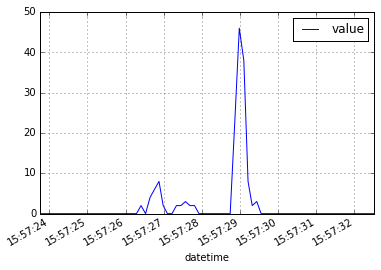

In [123]:
df.plot()

In [124]:
df.to_csv('text.csv')

In [128]:
import os
print(os.getcwd(),os.listdir(os.getcwd()))

#If we then run a kernel on host, we can use it to grab the file over via scp:
#!scp robot@192.168.1.106:/home/robot/text.csv ./
#and then do heavier weight charting on the host using a host based kernel

('/home/robot', ['.pip', 'rik_kernel.json', '.profile', '.bashrc', '.ipython', '.idlerc', '.bash_logout', '.ssh', '.cache', '.bash_history', 'text.csv', '.config'])


In [1]:
#Free up memory
dd=None
df=None

### Final Challenge

What is the final challenge?